# LanGraph for conversational AI Agent

define the behavior of your agents using three key components in LangGraph:

`State`: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel. The State consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state. 

`Nodes`: Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an updated State.

`Edges`: Python functions that determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions.

`Reducers`: Reducers are key to understanding how updates from nodes are applied to the State. Each key in the State has its own independent reducer function. If no reducer function is explicitly specified then it is assumed that all updates to that key should override it.


When a Node completes its operation, it sends messages along one or more edges to other node(s). These recipient nodes then execute their functions, pass the resulting messages to the next set of nodes, and the process continues

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [3]:
# since state is the most important piece in the flow, we define the state class first

class State(TypedDict):
    messages: Annotated[list, add_messages]
    # state holds the list of messages, when new message is given to state, 
    # reducer function (add_messages), append that message to the list
    # keeping all the previous conversation 
    # if no reducer fn, then it overwrites, instead of appending

In [4]:
graph_builder = StateGraph(State)

In [6]:
# next we can define our llm model to use
import os
from api_keys import GROQ_API_KEY
from langchain.chat_models import init_chat_model

os.environ['GROQ_API_KEY'] = GROQ_API_KEY

llm_model = init_chat_model(model="llama3-8b-8192", model_provider = "groq")

In [9]:
# we can create first node as chat node where llm will be used
def chat_node(state: State):
    # this node will take the stored messages in state and run 
    # chat llm on it
    result = {'messages': [llm_model.invoke(state["messages"])]}
    return result

# add this node to the graph, first argument would be name of node
graph_builder.add_node("chat_node", chat_node)

In [11]:
# next we would want this chat node to be the first start entry point
# and also the end point (as now we just would have one node)
graph_builder.add_edge(START, "chat_node")
graph_builder.add_edge("chat_node", END)

In [15]:
# now we have the basic graph, START-> CHAT_NODE -> END
# we can compile the graph
graph = graph_builder.compile()

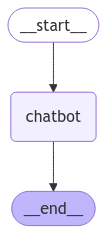

# Graph Streaming
To traverse through the graph, Langchain provides streaming methods
`.stream` and `.astream` are sync and async methods for streaming back outputs from a graph run. There are several different modes you can specify when calling these methods (e.g. `graph.stream(..., mode="...")):

`"values"`: This streams the full value of the state after each step of the graph.

`"updates"`: This streams the updates to the state after each step of the graph. If multiple updates are made in the same step (e.g. multiple nodes are run) then those updates are streamed separately.

`"custom"`: This streams custom data from inside your graph nodes.

`"messages"`: This streams LLM tokens and metadata for the graph node where LLM is invoked.

In [23]:
from langchain_core.messages import HumanMessage, SystemMessage
def run_graph(user_input: str):
    for event in graph.stream(
        {"messages": [HumanMessage(content = user_input)]}):
        for value in event.values():
            # printing latest message in state
            return "Chat: {}".format(value["messages"])

In [24]:
# running the chat bot, 
while True:
    user_input = str(input("User: "))

    if user_input.lower() in ["quit", "q", "exit"]:
        break
    print(run_graph(user_input))

User:  hello


Chat: [AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.021666667, 'prompt_time': 0.003949593, 'queue_time': 0.435477869, 'total_time': 0.02561626}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'stop', 'logprobs': None}, id='run-b93c148f-c62e-40ae-a526-3654541a7bba-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})]


User:  who are you


Chat: [AIMessage(content="I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human, but a computer program designed to simulate conversation, answer questions, and even generate text or code.\n\nI was trained on a massive dataset of text from the internet and can generate responses to a wide range of topics and questions. I can understand natural language and respond in a way that's intended to mimic human-like conversation.\n\nI'm not perfect and can make mistakes, but I'm constantly learning and improving my abilities based on the interactions I have with users like you.\n\nSo, what would you like to talk about?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 13, 'total_tokens': 149, 'completion_time': 0.113333333, 'prompt_time': 0.002960508, 'queue_time': 0.5069301039999999, 'total_time': 0.116293841}, 'model_name': 'llama3-8b-8192', 'system_finger

User:  q


In [30]:
graph.chat_node()

AttributeError: 'CompiledStateGraph' object has no attribute 'chat_node'